In [1]:
import os
import networkx as nx
# import igraph as ig
# import graph_tool.all as gt
import numpy as np
from multiprocessing import Pool
import time
import subprocess
import func_timeout
import cProfile
# import ipython_memory_usage 
# from memory_profiler import profile
%load_ext memory_profiler
import matplotlib.pyplot as plt
# %matplotlib inline

import sys
sys.path.insert(0, os.path.abspath('..'))
from dataset.H_patterns import Motifs
from utilities.load_data import extract_edge_list_from_edgelist, extract_edge_list_from_adjlist, nx_to_grf, timeout_check
from homsearch_master.sub_iso import VF2, VF3
from homsearch_master.subgraphs import sub_GMP, sub_GMP_with_iso_checking
from homsearch_master.subgraphs import GMP, GMP_multiprocess, VF_2, VF_2_multiprocess, VF_2_multiprocess_gt, VF_3, VF_3_multiprocess

### ❌homlib  ¯\_(ツ)_/¯

In [ ]:
import homlib
T = homlib.Graph(3)
T.addEdge(0,1)
T.addEdge(1,2)

G = homlib.Graph(30)
G.addEdge(0,1)
G.addEdge(1,2)
G.addEdge(2,0)

print(homlib.hom(T, G))

In [3]:
from utilities.partition import partition, multiplier_list, partition_with_iso_checking
def graph_trans(G):
    "graph data structure transformation"
    G_ = homlib.Graph(nx.number_of_nodes(G))
    for e in G.edges:
        G_.addEdge(e[0], e[1])
    return G_


def sub_GMP_homlib(H_list, G):
    graph_list, mul_list = partition_with_iso_checking(H)
    hom_list = []
    G_ = graph_trans(G)
    for h in graph_list:
        hom = homlib.hom(graph_trans(h), G_)
        hom_list.append(hom)
    num_sub = int(np.dot(np.array(mul_list), np.array(hom_list)) / VF2.count_isomorphisms_nx(H, H))

    return num_sub

In [ ]:
sub_GMP_homlib(motifs_1, G_nx)

### 📍H

In [2]:
motifs_1 = [] ### nx
for k, v in Motifs.motifs.items():
    motifs_1.append(nx.from_dict_of_lists(v))
    
motifs_2 = []
for k, v in Motifs.connected_motifs.items():
    motifs_2.append(nx.from_dict_of_lists(v))

In [ ]:
motifs_1 = [] ### gt
for k, v in Motifs.motifs.items():
    h = nx.from_dict_of_lists(v)
    h_ = gt.Graph(directed=False)
    h_.add_vertex(nx.number_of_nodes(h))
    gt.Graph.add_edge_list(h_, edge_list=h.edges)
    motifs_1.append(h_)

In [2]:
H_clique = []
for n in range(3, 6):
    H_clique.append(nx.complete_graph(n))

In [3]:
H_path = []
for n in range(3, 6):
    H_path.append(nx.path_graph(n))

In [4]:
seed = 0
H_tree = []
for n in range(3, 6):
    H_tree.append(nx.random_tree(n, seed))

In [7]:
seed = 0
H_gnm = []
for n in range(3, 7):
    for m in range(n, int(n**2/4)):
        H_gnm.append(nx.dense_gnm_random_graph(n, m, seed))

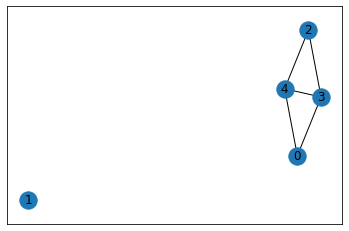

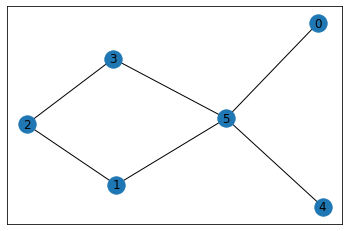

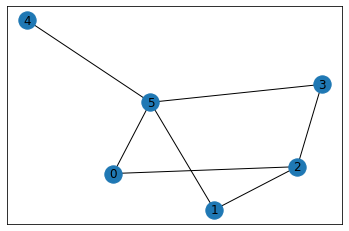

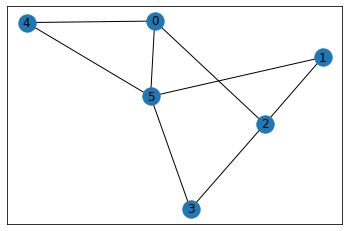

In [8]:
for h in H_gnm:
    nx.draw_networkx(h)
    plt.show()

### 📍Real-world Networks
| Network | n |  m |    degree | fill |
|:----------     |--------      |-------     |----      |----       |
|<img width=150/>|<img width=100/>|<img width=100/>|<img width=100/>|<img width=100/>|
|[Physicians](http://konect.uni-koblenz.de/networks/moreno_innovation) |241 | 1098 |9.1120|0.0189830|
|[ChicagoRegional](http://konect.uni-koblenz.de/networks/tntp-ChicagoRegional)|1467|1298|1.7696|0.0012071|
|[Euroroad](http://konect.uni-koblenz.de/networks/subelj_euroroad)|1174|1417|2.4140|0.0020579|
|[U. Rovira i Virgili](http://konect.uni-koblenz.de/networks/arenas-email)|1133|5451|9.6222|0.0085002|
|[Facebook(NIPS)](http://konect.uni-koblenz.de/networks/ego-facebook)|2888|2981|2.0644|0.0007151|
|[Hamsterster full](http://konect.uni-koblenz.de/networks/petster-hamster)|2426|16631|13.7110|0.0056539|

In [2]:
edge_list = extract_edge_list_from_edgelist(os.path.abspath("..") +
                                                "/dataset/tntp-ChicagoRegional/out.tntp-ChicagoRegional", ' ')
G_nx = nx.from_edgelist(edge_list) 

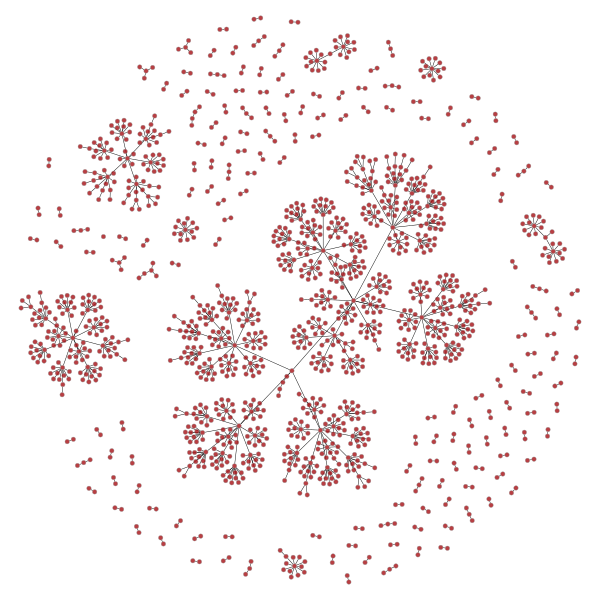

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x105163690, at 0x126865d10>

In [3]:
# G_ig = ig.Graph.TupleList(edges=edge_list)

G_gt = gt.Graph(directed=False)
G_gt.add_vertex(nx.number_of_nodes(G_nx))
gt.Graph.add_edge_list(G_gt, edge_list=edge_list)
gt.graph_draw(G_gt, edge_color="black")

In [4]:
PATH_DATA = os.path.join(os.path.abspath(".."),'dataset')
path_Pysicians = "moreno_innovation/out.moreno_innovation_innovation"
path_ChicagoRegional = "tntp-ChicagoRegional/out.tntp-ChicagoRegional"
path_Euroroad = "subelj_euroroad/out.subelj_euroroad_euroroad"
path_Rovira = "arenas-email/out.arenas-email"
# path_Facebook = "ego-facebook/out.ego-facebook"    # 8791.95 seconds and out of memory
path_Hamsterster = "petster-hamster/out.petster-hamster"
path_list = [path_Pysicians, path_ChicagoRegional, path_Euroroad, path_Rovira, path_Hamsterster]

G_list = []
for p in path_list:
    edge_list = extract_edge_list_from_edgelist(os.path.join(PATH_DATA, p), ' ')
    G_nx = nx.from_edgelist(edge_list) 
    G_list.append(G_nx)

In [9]:
### GMP
t_GMP_multiprocess = []
for G in G_list:
    %memit t = GMP_multiprocess(motifs_1, G)[1] 
    t_GMP_multiprocess.append(t)
print(t_GMP_multiprocess)

Running time: 0.23 seconds
peak memory: 137.61 MiB, increment: 0.09 MiB
Running time: 0.74 seconds
peak memory: 137.63 MiB, increment: 0.07 MiB
Running time: 0.95 seconds
peak memory: 137.63 MiB, increment: 0.04 MiB
Running time: 63.97 seconds
peak memory: 137.84 MiB, increment: 0.25 MiB
Running time: 1318.85 seconds
peak memory: 138.05 MiB, increment: 0.25 MiB
[0.22563505172729492, 0.7447900772094727, 0.9525508880615234, 63.96747326850891, 1318.848786830902]


In [7]:
### VF3
t_VF3_multiprocess = []
for G in G_list:
    try:
        %memit t = VF_3_multiprocess(motifs_1, G)[1]
    except func_timeout.exceptions.FunctionTimedOut:
        t = 'times out'
    t_VF3_multiprocess.append(t)
print(t_VF3_multiprocess)

Running time: 22.65 seconds
peak memory: 136.34 MiB, increment: 0.30 MiB
Running time: 22.77 seconds
peak memory: 136.37 MiB, increment: 0.08 MiB
Running time: 22.82 seconds
peak memory: 136.37 MiB, increment: 0.05 MiB
Running time: 73.61 seconds
peak memory: 136.58 MiB, increment: 0.27 MiB
Running time: 971.46 seconds
peak memory: 136.80 MiB, increment: 0.29 MiB
[22.64578080177307, 22.769484043121338, 22.823588132858276, 73.61079239845276, 971.4612128734589]


In [8]:
### VF2
t_VF2_multiprocess = []
for G in G_list:
    try:
        %memit t = VF_2_multiprocess(motifs_1, G)[1]
    except func_timeout.exceptions.FunctionTimedOut:
        t = 'times out'
    t_VF2_multiprocess.append(t)
print(t_VF2_multiprocess)

Process ForkPoolWorker-47:
Process ForkPoolWorker-48:
Process MemTimer-46:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/usr/local/lib/python3.7/site-packages/memory_profiler.py", line 233, in run
    stop = self.pipe.poll(self.interval)
  File "/usr/local/Cellar/p

In [4]:
### gt
G_list = []
for p in path_list:
    edge_list = extract_edge_list_from_edgelist(os.path.join(PATH_DATA, p), ' ')
    G_nx = nx.from_edgelist(edge_list)
    G_gt = gt.Graph(directed=False)
    G_gt.add_vertex(nx.number_of_nodes(G_nx))
    gt.Graph.add_edge_list(G_gt, edge_list=edge_list)
    G_list.append(G_gt)

In [ ]:
### VF2_gt
t_VF2_multiprocess_gt = []
for G in G_list:
    try:
        %memit t = VF_2_multiprocess_gt(motifs_1, G)[1]
    except func_timeout.exceptions.FunctionTimedOut:
        t = 'times out'
    t_VF2_multiprocess_gt.append(t)
print(t_VF2_multiprocess_gt)

Running time: 45.89 seconds
peak memory: 219.80 MiB, increment: 0.03 MiB
Running time: 206.15 seconds
peak memory: 218.56 MiB, increment: 0.19 MiB
Running time: 100.62 seconds
peak memory: 186.54 MiB, increment: 0.87 MiB


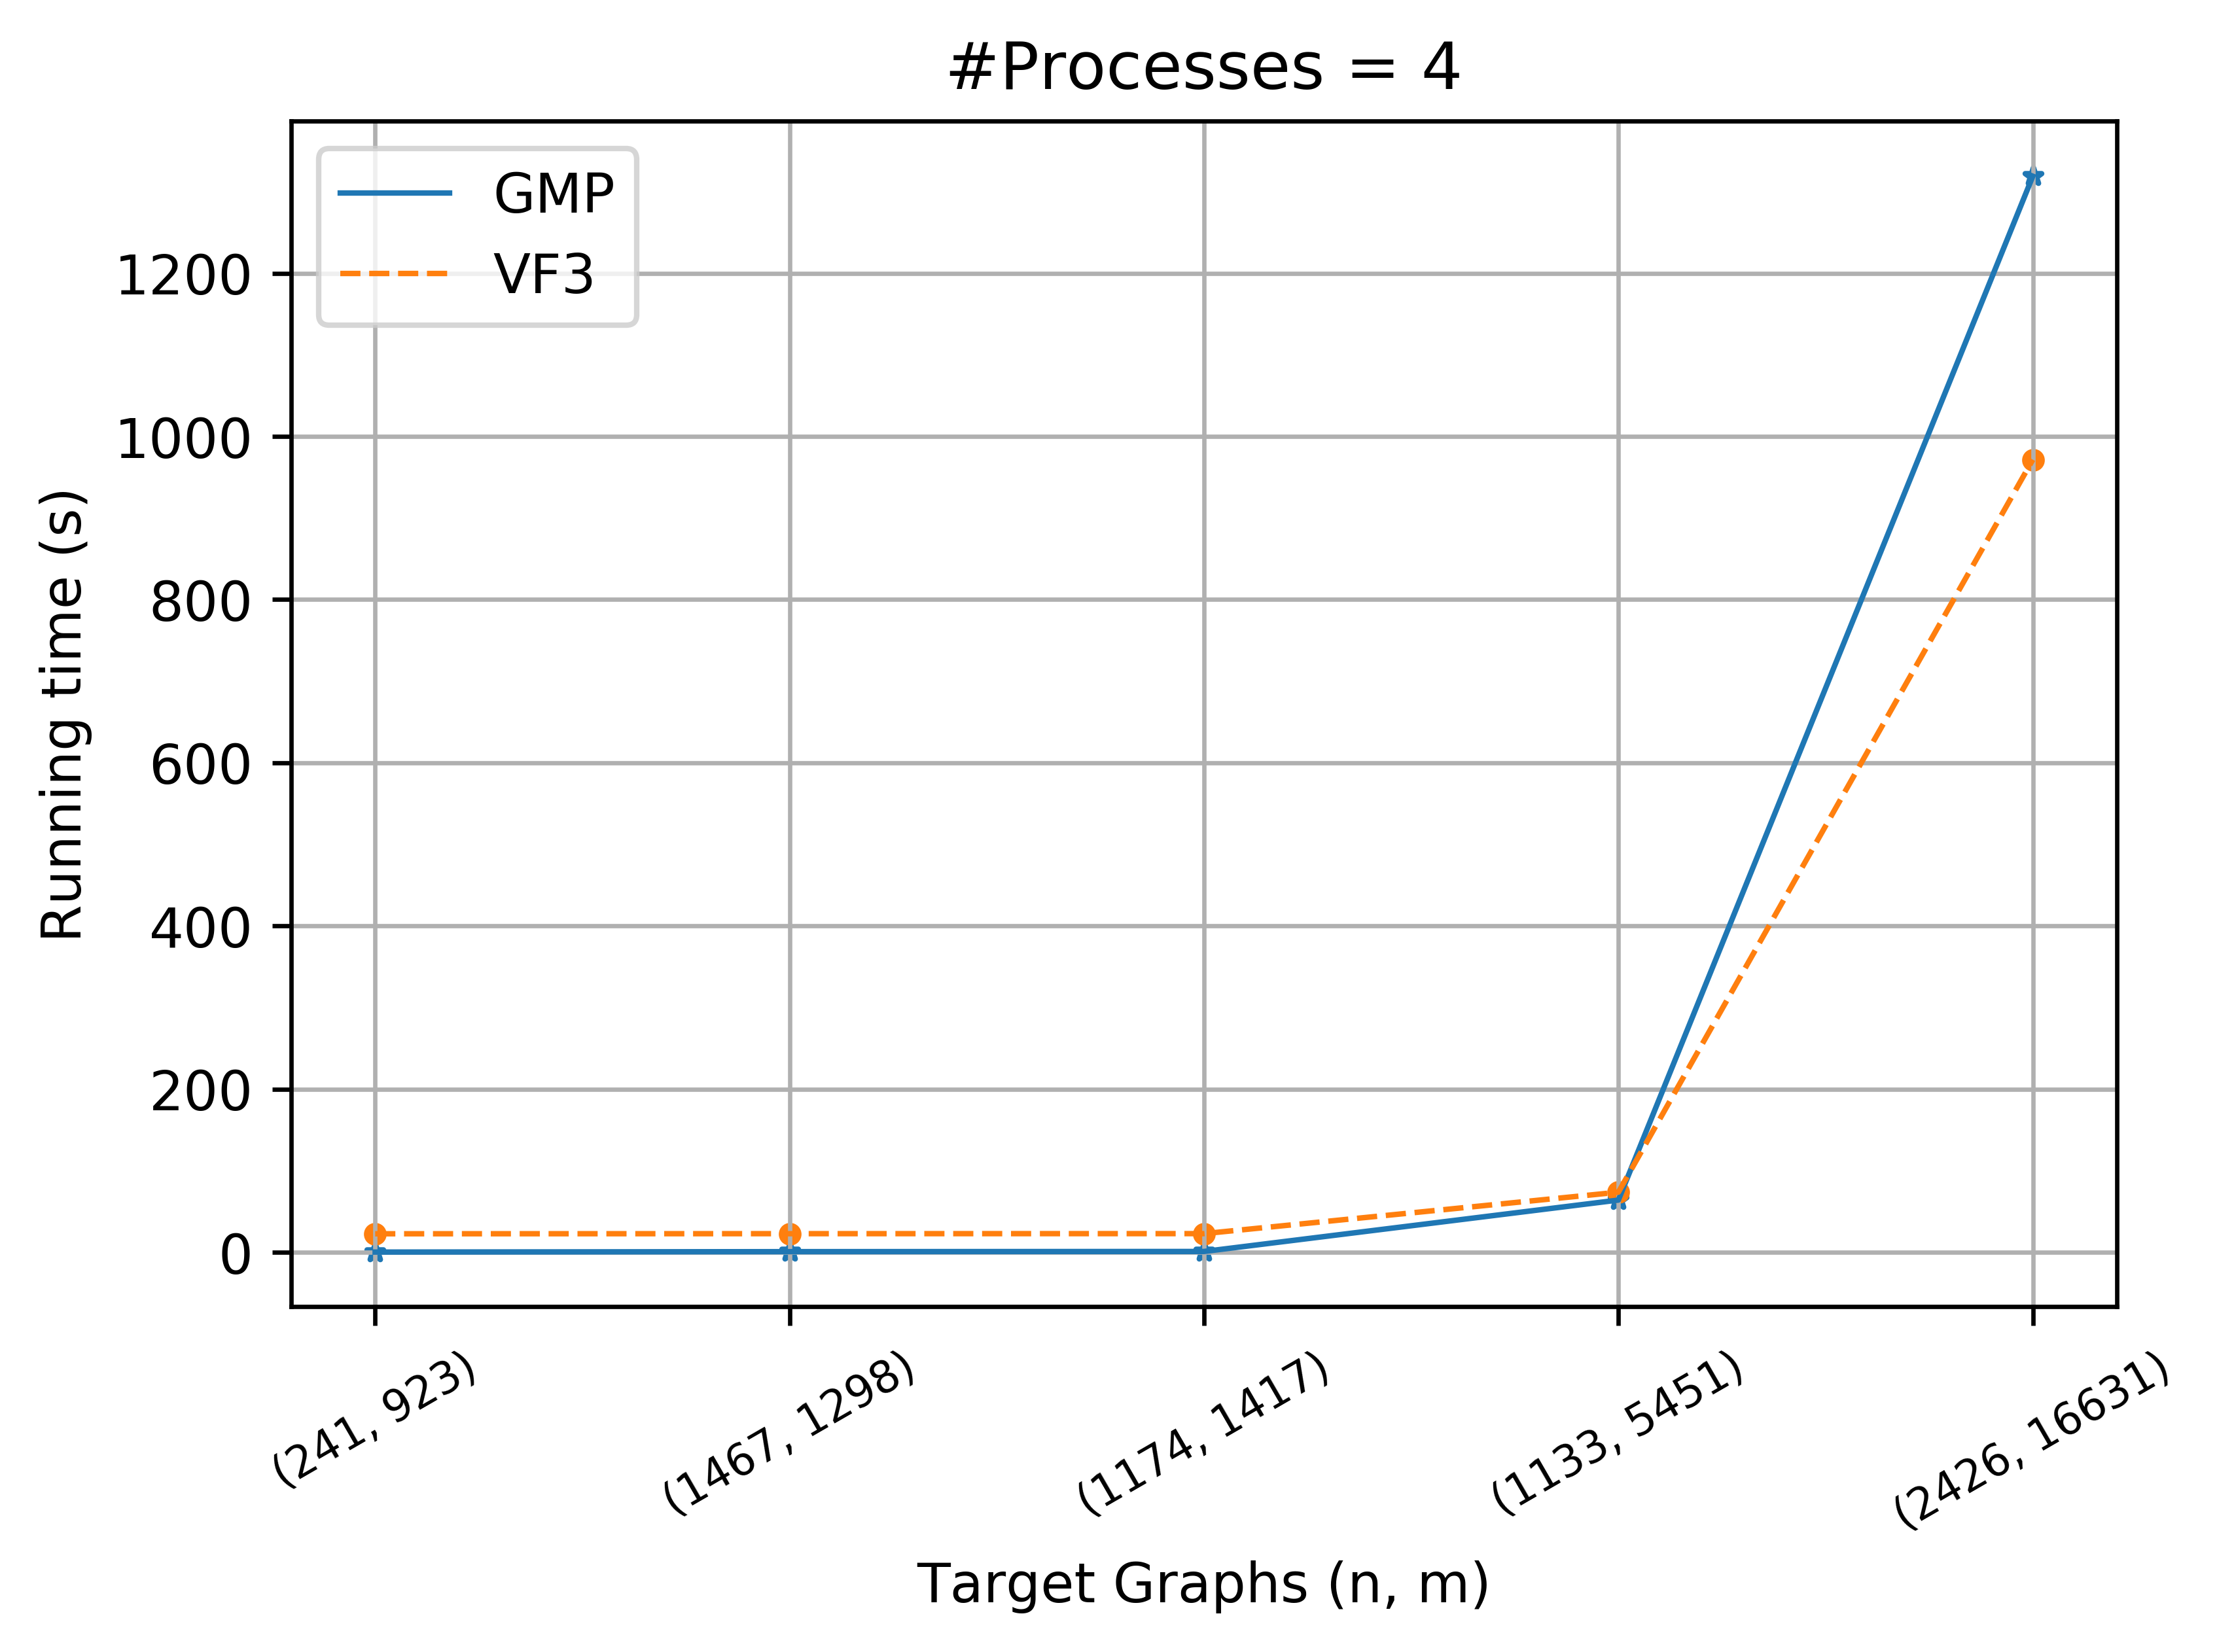

In [14]:
# motifs_1 + realworld
t_GMP_multiprocess = [0.22563505172729492, 0.7447900772094727, 0.9525508880615234, 63.96747326850891, 1318.848786830902]
t_VF3_multiprocess = [22.64578080177307, 22.769484043121338, 22.823588132858276, 73.61079239845276, 971.4612128734589]
t_VF3_multiprocess = timeout_check(t_VF3_multiprocess, 1800)
plt.figure(dpi=600)
plt.title('#Processes = 4')
x = np.arange(len(G_list))
ax = plt.gca()
ax.set_xlabel('Target Graphs (n, m)')
plt.xticks(rotation=30, ha='right')
plt.setp(ax, xticks=x, xticklabels=['({}, {})'.format(nx.number_of_nodes(g), nx.number_of_edges(g)) for g in G_list])
plt.setp(ax.get_xticklabels(), fontsize=8, horizontalalignment="center")
ax.set_ylabel('Running time (s)')
# ax.set_ylim([-1,4])
# y_list = range(-1, 4)
# plt.setp(ax, yticks=y_list, yticklabels=[10**y for y in y_list])
# plt.setp(ax.get_yticklabels(), fontsize=8)
# ax.plot(x, np.log10(t_GMP_multiprocess), label='GMP', linewidth=1.0)
# ax.scatter(x, np.log10(t_GMP_multiprocess), marker='*', s=10)
# ax.plot(x, np.log10(t_VF3_multiprocess), '--', label='VF3', linewidth=1.0)
# ax.scatter(x, np.log10(t_VF3_multiprocess), marker='o', s=10)
ax.plot(x, t_GMP_multiprocess, label='GMP', linewidth=1.0)
ax.scatter(x, t_GMP_multiprocess, marker='*', s=10)
ax.plot(x, t_VF3_multiprocess, '--', label='VF3', linewidth=1.0)
ax.scatter(x, t_VF3_multiprocess, marker='o', s=10)
ax.grid()
ax.legend(loc='best')

---

In [5]:
GMP(motifs_1, G_nx, False)

Running time: 2.773 seconds
CPU times: user 2.76 s, sys: 10.5 ms, total: 2.77 s
Wall time: 2.77 s


([1901570, 5729, 0, 1391949240, 836024, 8387256, 0, 9807, 16738, 0, 0, 0, 0],
 2.7732319831848145)

In [4]:
GMP(motifs_1, G_nx)

Running time: 1.65 seconds


([1901570, 5729, 0, 836024, 8387256, 0, 9807, 16738, 0, 0, 0, 0],
 1.653494119644165)

In [4]:
%time GMP_multiprocess(motifs_1, G_nx, False)

Running time: 0.96 seconds
CPU times: user 25.7 ms, sys: 16.6 ms, total: 42.3 ms
Wall time: 965 ms


([1901570, 5729, 0, 836024, 8387256, 0, 9807, 16738, 0, 0, 0, 0],
 0.9633369445800781)

In [6]:
%timeit GMP_multiprocess(motifs_1, G_nx)

Running time: 0.740 seconds
Running time: 0.739 seconds
Running time: 0.732 seconds
Running time: 0.735 seconds
Running time: 0.736 seconds
Running time: 0.735 seconds
Running time: 0.736 seconds
Running time: 0.740 seconds
739 ms ± 2.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
try:
    VF_2(motifs_1, G_nx)
except func_timeout.exceptions.FunctionTimedOut:
    print('VF2 times out')

VF_2 times out


In [5]:
%time VF_2_multiprocess(motifs_2, G_nx)

Running time: 46.02 seconds
CPU times: user 59.7 ms, sys: 22.5 ms, total: 82.2 ms
Wall time: 46 s


([1298,
  5729,
  0,
  9807,
  16738,
  0,
  0,
  0,
  0,
  33331,
  43943,
  0,
  0,
  84188,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 46.01861810684204)

In [10]:
%time VF_3_multiprocess(motifs_2, G_nx)

Running time: 110.48 seconds
CPU times: user 84.8 ms, sys: 25.7 ms, total: 110 ms
Wall time: 1min 50s


([1298,
  5729,
  0,
  9807,
  16738,
  0,
  0,
  0,
  0,
  33331,
  43943,
  0,
  0,
  84188,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 110.4808611869812)

In [6]:
%time GMP_multiprocess(motifs_2, G_nx)

Running time: 4.64 seconds
CPU times: user 40.2 ms, sys: 15.7 ms, total: 56 ms
Wall time: 4.64 s


([1298,
  5729,
  0,
  9807,
  16738,
  0,
  0,
  0,
  0,
  33331,
  43943,
  0,
  0,
  84188,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 4.637042045593262)

In [9]:
%time GMP_multiprocess(motifs_2, G_nx, False)

Running time: 6.73 seconds
CPU times: user 42.2 ms, sys: 16.3 ms, total: 58.5 ms
Wall time: 6.73 s


([1298,
  5729,
  0,
  9807,
  16738,
  0,
  0,
  0,
  0,
  33331,
  43943,
  0,
  0,
  84188,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 6.731052875518799)

In [4]:
VF_3(motifs_1, G_nx)

Running time: 85.95 seconds


([1901570, 5729, 0, 836024, 8387256, 0, 9807, 16738, 0, 0, 0, 0],
 85.95497107505798)

In [4]:
VF_3_multiprocess(motifs_1, G_nx)

Running time: 22.82 seconds


([1901570, 5729, 0, 836024, 8387256, 0, 9807, 16738, 0, 0, 0, 0],
 22.82194995880127)

---
### 📍Random Graphs
- nx.generators.random_graphs.fast_gnp_random_graph(n, p, seed)
- nx.generators.random_graphs.gnm_random_graph(n, m, seed)
- nx.generators.random_graphs.powerlaw_cluster_graph(n, m, p, seed)

In [15]:
seed = 0
G_list = []
for n in [500, 1000]:
    for p in [0.01, 0.02]:  # density/fill
        G_list.append(nx.generators.random_graphs.fast_gnp_random_graph(n, p, seed))
for n in [2000, 4000]:
    for p in [0.002, 0.005]: 
        G_list.append(nx.generators.random_graphs.fast_gnp_random_graph(n, p, seed))

In [4]:
for g in G_list:
    print(nx.number_of_edges(g))

1254
2460
4935
10049
3926
10058
16034
40140


In [ ]:
import graph_tool.all as gt 
G_nx = G_list[1]
G_gt = gt.Graph(directed=False)
G_gt.add_vertex(nx.number_of_nodes(G_nx))
gt.Graph.add_edge_list(G_gt, edge_list=G_nx.edges)

gt.graph_draw(G_gt, edge_color="black")  ### Viualization

In [ ]:
### GMP
t_GMP_multiprocess = []
for G in G_list:
    %memit t = GMP_multiprocess(motifs_1, G)[1] 
    t_GMP_multiprocess.append(t)
print(t_GMP_multiprocess)

Running time: 0.23 seconds
peak memory: 125.76 MiB, increment: 0.29 MiB
Running time: 0.74 seconds
peak memory: 125.87 MiB, increment: 0.13 MiB
Running time: 0.85 seconds
peak memory: 125.96 MiB, increment: 0.12 MiB
Running time: 62.44 seconds
peak memory: 126.56 MiB, increment: 0.64 MiB


In [ ]:
### VF2
t_VF2_multiprocess = []
for G in G_list:
    try:
        %memit t = VF_2_multiprocess(motifs_1, G)[1]
    except func_timeout.exceptions.FunctionTimedOut:
        t = 'times out'
    t_VF2_multiprocess.append(t)
print(t_VF2_multiprocess)

Running time: 252.35 seconds
peak memory: 148.18 MiB, increment: 0.88 MiB
Running time: 1032.16 seconds
peak memory: 148.29 MiB, increment: 0.15 MiB


In [6]:
### VF3
t_VF3_multiprocess = []
for G in G_list:
    try:
        %memit t = VF_3_multiprocess(motifs_1, G)[1]
    except func_timeout.exceptions.FunctionTimedOut:
        t = 'times out'
    t_VF3_multiprocess.append(t)
print(t_VF3_multiprocess)

Running time: 22.90 seconds
peak memory: 153.22 MiB, increment: 0.05 MiB
Running time: 25.26 seconds
peak memory: 153.17 MiB, increment: 0.00 MiB
Running time: 42.82 seconds
peak memory: 152.94 MiB, increment: 0.11 MiB
Running time: 185.36 seconds
peak memory: 152.88 MiB, increment: 0.00 MiB
Running time: 27.94 seconds
peak memory: 150.99 MiB, increment: 0.10 MiB
Running time: 124.89 seconds
peak memory: 151.28 MiB, increment: 0.34 MiB
Running time: 266.95 seconds
peak memory: 151.42 MiB, increment: 0.20 MiB
[22.896886110305786, 25.264552354812622, 42.818172216415405, 185.36003708839417, 27.93529963493347, 124.88577508926392, 266.94862508773804, 'times out']


Process ForkPoolWorker-78:
Process ForkPoolWorker-77:
Process ForkPoolWorker-79:
Process ForkPoolWorker-80:
Process MemTimer-76:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.5/Framework

In [16]:
### motif_1 + random graphs
t_GMP_multiprocess = [0.54,2.40,5.16,30.18, 4.16, 35.10, 40.55, 432.02]
t_VF2_multiprocess = [252.35, 1032.16]
t_VF2_multiprocess.extend(['times out']*6)
t_VF3_multiprocess = [22.896886110305786, 25.264552354812622, 42.818172216415405, 185.36003708839417, 27.93529963493347, 124.88577508926392, 266.94862508773804, 'times out']

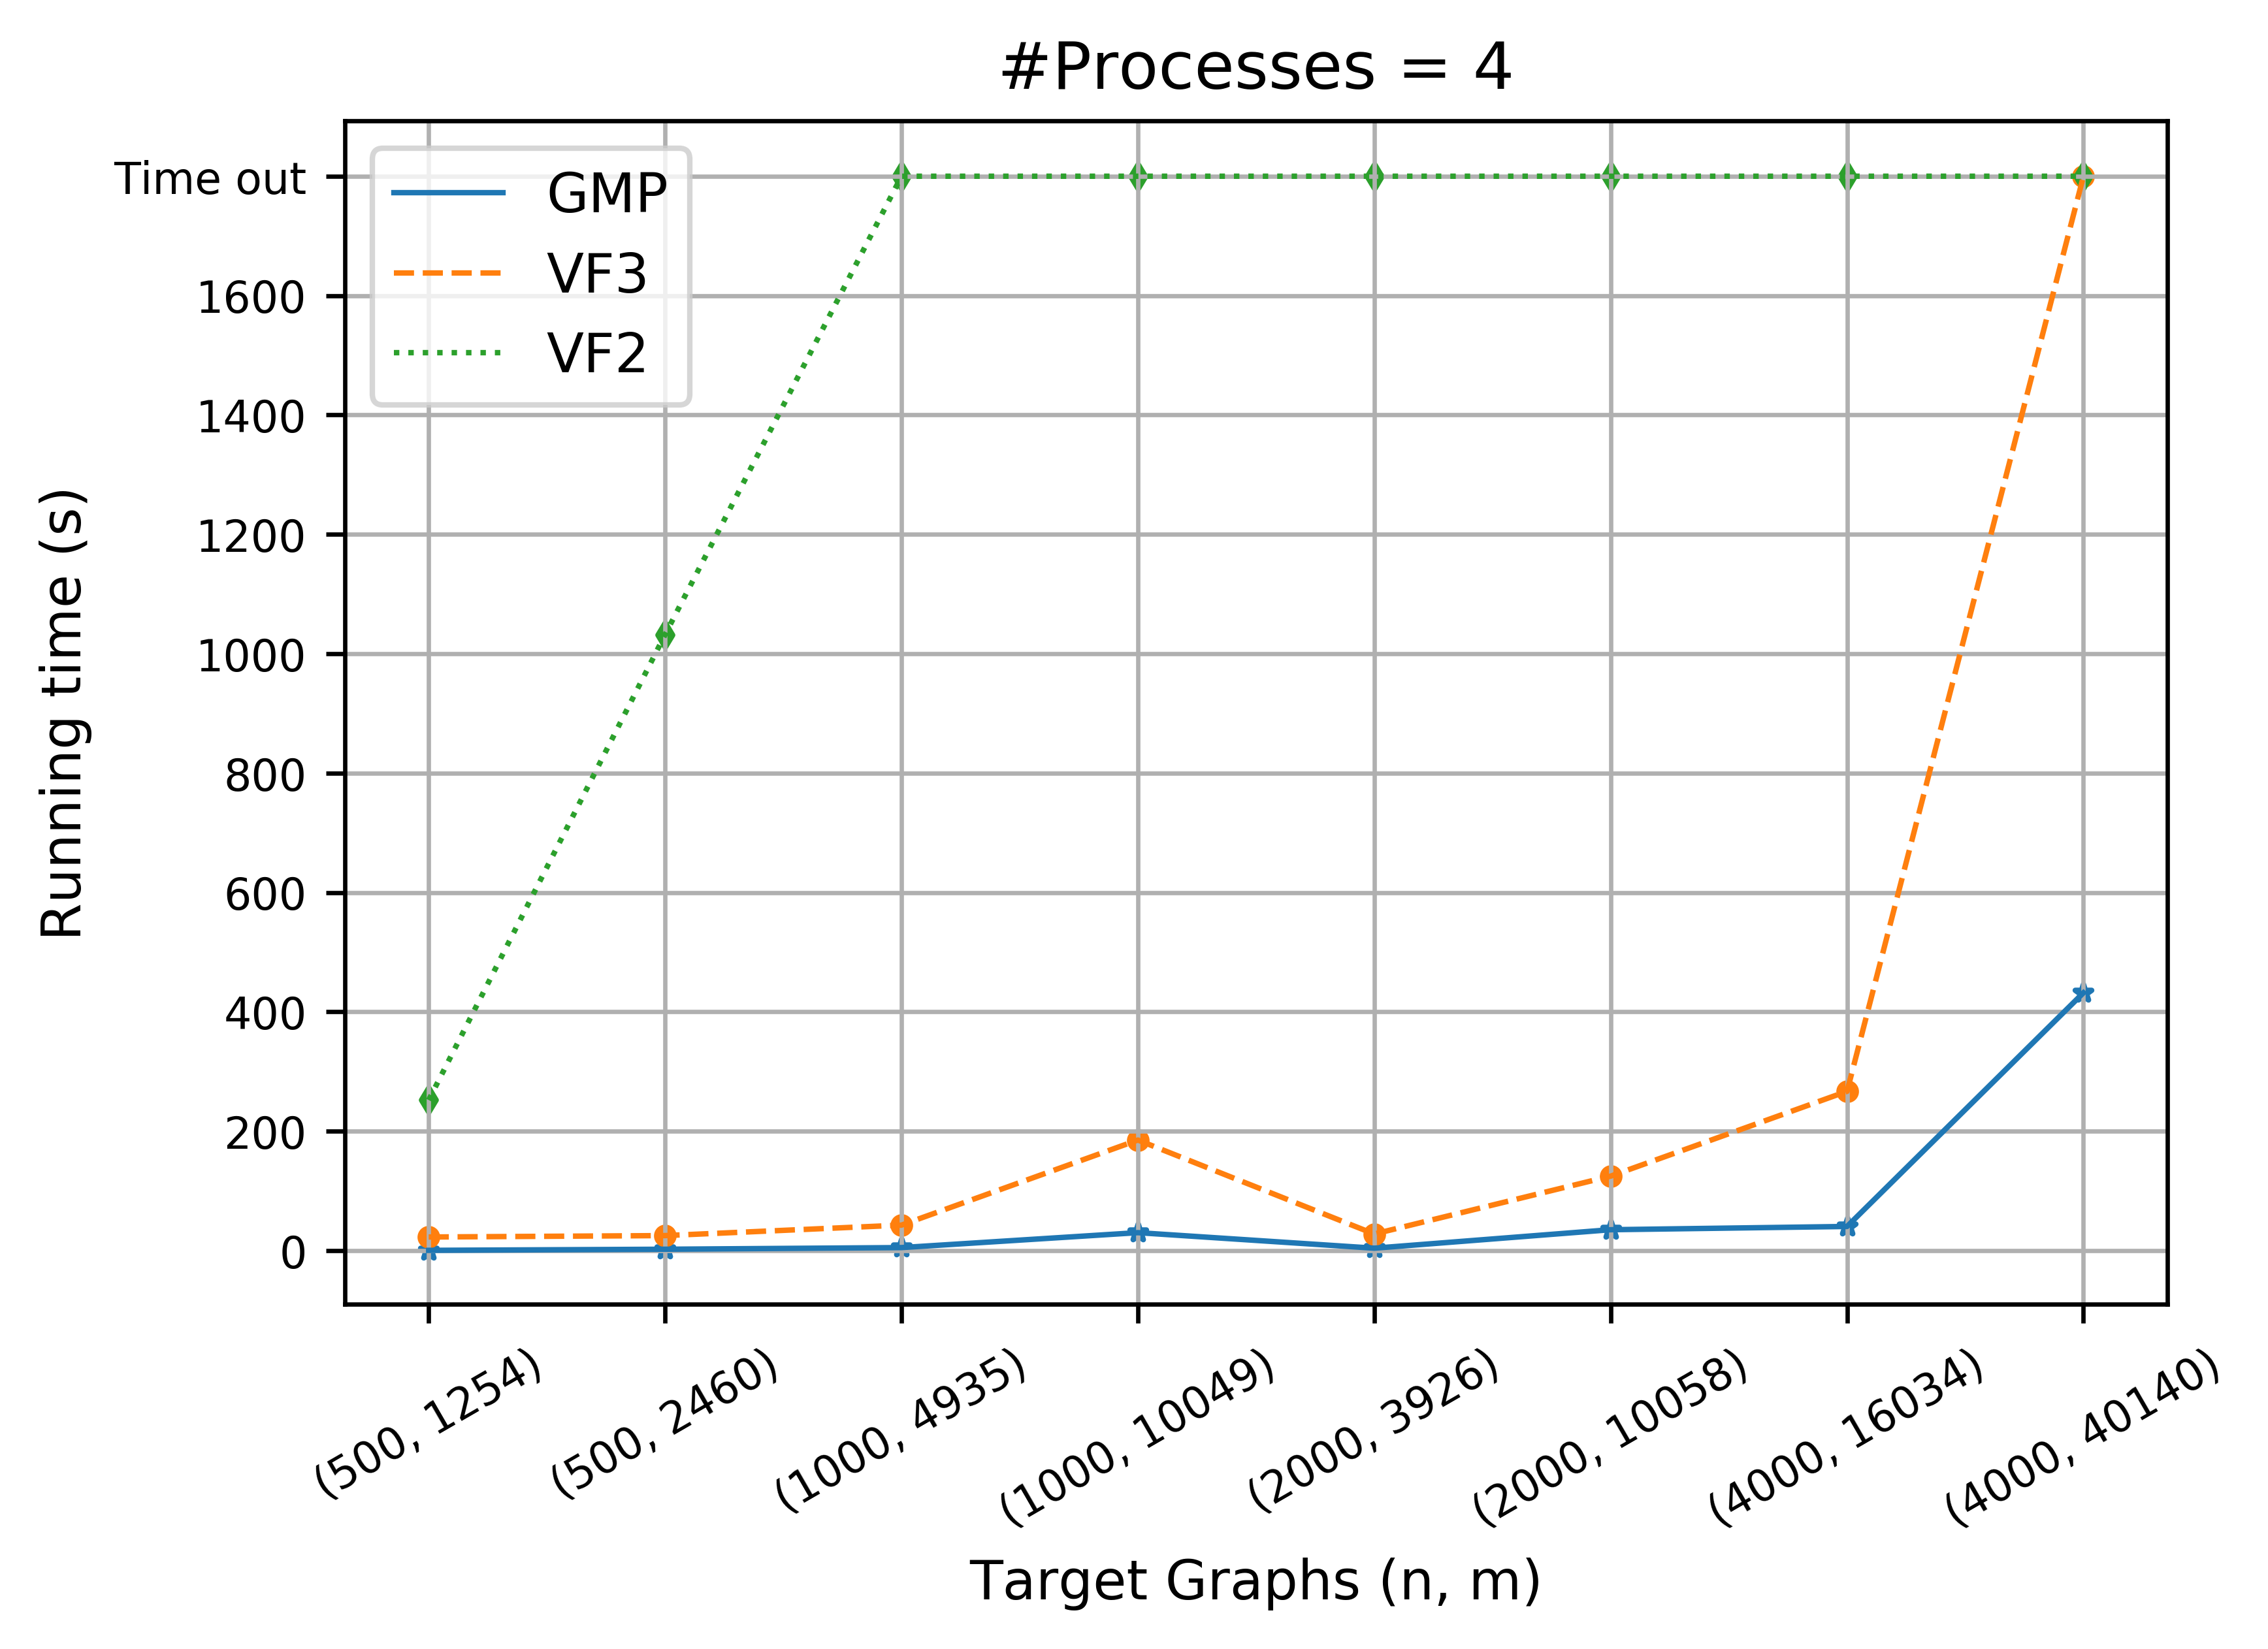

In [18]:
t_VF2_multiprocess = timeout_check(t_VF2_multiprocess, 1800)
t_VF3_multiprocess = timeout_check(t_VF3_multiprocess, 1800)
plt.figure(dpi=600)
plt.title('#Processes = 4')
x = np.arange(len(G_list))
ax = plt.gca()
ax.set_xlabel('Target Graphs (n, m)')
plt.xticks(rotation=30, ha='right')
plt.setp(ax, xticks=x, xticklabels=['({}, {})'.format(nx.number_of_nodes(g), nx.number_of_edges(g)) for g in G_list])
plt.setp(ax.get_xticklabels(), fontsize=8, horizontalalignment="center")
ax.set_ylabel('Running time (s)')
y_list = [200*i for i in range(9)]
y_list.append('Time out')
plt.setp(ax, yticks=[200*i for i in range(10)], yticklabels=y_list)
plt.setp(ax.get_yticklabels(), fontsize=8)
ax.plot(x, t_GMP_multiprocess, label='GMP', linewidth=1.0)
ax.scatter(x, t_GMP_multiprocess, marker='*', s=10)
ax.plot(x, t_VF3_multiprocess, '--', label='VF3', linewidth=1.0)
ax.scatter(x, t_VF3_multiprocess, marker='o', s=10)
ax.plot(x, t_VF2_multiprocess, ':', label='VF2', linewidth=1.0)
ax.scatter(x, t_VF2_multiprocess, marker='d', s=10)
# ax.plot(x, np.log10(t_GMP_multiprocess), label='GMP')
# ax.scatter(x, np.log10(t_GMP_multiprocess), marker='*')
# ax.plot(x, np.log10(t_VF3_multiprocess), '--', label='VF3')
# ax.scatter(x, np.log10(t_VF3_multiprocess), marker='o')
# ax.plot(x, np.log10(t_VF2_multiprocess), ':', label='VF2')
# ax.scatter(x, np.log10(t_VF2_multiprocess), marker='d')
ax.grid()
ax.legend(loc='best') 

---

In [14]:
H_list = []
H_list.extend(H_clique)
H_list.extend(H_path)
# H_list.extend(H_tree)
# H_list.extend(H_gnm)

In [11]:
from utilities.partition import partition, multiplier_list, partition_with_iso_checking

In [12]:
for H in H_list:
    print(multiplier_list([eval(p) for p in list(partition(H).keys())]))

[1]
[1]
[1]
[1, -1]
[1, -1, -1, -1, 1]
[1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 2, 1, -2]
[1, -1]
[1, -1, -1, -1, 2]
[1, -1, -1, -1, -1, -1, -1, 2, 1, 1, 2, 1, 1, 1, -2]
[1, -1, -1, -1, -1, -1, 2, 1, 1]
[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, -2, -2, -1, -2, -6, -2, -2, -1, -2, -1, -2, 6]
[1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, -2, -2, -1, -2, -6, -1, -2, -1, -2, 6]
[1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, -2, -1, -2, -2, -1]


In [13]:
for H in H_list:
    print(partition_with_iso_checking(H)[1])

[1]
[1]
[1]
[1, -1]
[1, -1, -2, 1]
[1, -1, -2, -2, -1, 5, 3, -2]
[1, -1]
[1, -3, 2]
[1, -3, -2, -1, 5, 4, -2]
[1, -4, -1, 4]
[1, -5, -1, -2, -1, 6, 6, 6, 5, 2, -6, -17, 6]
[1, -3, -3, -1, -1, 3, 6, 9, 2, -2, -17, 6]
[1, -3, -2, -1, -1, 7, 7, -8]
